In [1]:
# Import packages
import numpy as np
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt

# Load data
df = pd.read_parquet('data_exjobb_070425.parquet')
df.head()

,TransactionId,SalePrice,Lat,Lon,BuildingAge,UtilityArea,LotArea,QualityScore,CloseToBeach,EnergyPerformance,...,MunicipalityMoveInFromCountyFrac,MunicipalityMoveOutToCountyFrac,MunicipalityMoveInFrac2yrChangeMean,MunicipalityMoveOutFrac2yrChangeMean,MunicipalityMoveInFromCountyFrac2yrChangeMean,MunicipalityMoveOutToCountyFrac2yrChangeMean,MunicipalityPopulationMeanDeviation,MedianRentMunicipality,MedianRentMunicipality2yrFracChangeMean,MedianRentMunicipalityMeanDeviation
0,10006194,3200000,56.742153,16.291778,48,143,480,36,0,60.0,...,0.025551,0.021314,0.001816,0.004082,0.000930,0.003437,4.373830,1155.0,0.091030,1.123790
1,10006232,1700000,57.278909,13.646019,54,120,750,32,0,114.0,...,0.010123,0.013869,-0.007777,0.006713,-0.001110,0.002518,1.843030,999.0,0.013451,0.972005
2,10006302,3500000,58.328009,15.103299,47,169,592,30,0,NaN,...,0.034871,0.028112,-0.003267,0.003278,-0.000932,0.000765,1.738860,1046.0,0.075010,1.017735
3,10006371,11200000,57.739437,14.122176,128,250,3311,30,0,88.0,...,0.013410,0.012764,-0.001062,0.001830,0.000457,0.000039,8.857676,1059.0,0.061507,1.030384
4,10006399,591000,57.784585,16.146614,112,87,3406,28,0,101.0,...,0.006766,0.006466,-0.001024,-0.000181,0.000441,0.000045,2.279611,909.0,0.009151,0.884437


In [2]:
# Create functions
def normalize_feature(feature):
    """Min-max normalization."""
    # This retains the relative position of the data points.
    return (feature-np.min(feature)) / (np.max(feature)-np.min(feature))

def normalize(data, axis=1):
    """Using the normalize_feature function on an np.array along a chosen axis."""
    norm_data = np.zeros_like(data)
    for i in range(data.shape[axis]):
        norm_data[:,i] = normalize_feature(data[:,i])
    return norm_data

def clustering(data, cluster_size=10, distance_type='euclidean'):
    """Takes data, minimum cluster size, distance metric and returns an array of the data with an added column at index 0 with the cluster label and the number of clusters."""
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size, metric=distance_type)
    clusterer.fit(data)
    return clusterer.labels_.max()+1 , np.insert(data, 0, clusterer.labels_.flatten(), axis=1)

def center_of_mass(number_of_clusters, clusters):
    cluster_centers = np.zeros((number_of_clusters, len(clusters[0])))
    balancing_vector = np.zeros_like(cluster_centers)
    clusters[:,0] += 1
    for i in range(len(clusters[:,None])):
        if clusters[i,0] > 0:
            cluster_centers[int(clusters[i,0])-1] += clusters[i]
            balancing_vector[int(clusters[i,0])-1] += 1 # Keeps track of how many points are in each cluster.
    return cluster_centers / balancing_vector




def reduce_dimension(vector,clusters):
    """Takes a vector and a set of clusters and reduces the vectors dimension to the number of clusters using the clusters as a basis."""
    # Vector projection
    transformation_matrix = np.zeros([len(clusters), len(vector)])

    for i in clusters:
        transformation_matrix[i] = center_of_mass(clusters[i])

    reduced_vector = transformation_matrix * vector
    return reduced_vector

# Outline
1. Find Clusters using hdbscan.
2. Find the centers of the clusters.
3. Reduce the dimensionality to the number of clusters and create a new vector space.
4. Find a suitable model for finding comparisons.

# Clustering

In [3]:
# Chaning to numpy array
data = df.to_numpy()
data_points = 100
play_data = data[0:data_points, 1:4] # Only using a part of the data.


data = play_data
data = data.astype(float) # Changing from type object to float so that numpy functions work properly.


# Normalizing the data
norm_data = normalize(data)

# Clustering
number_of_clusters, clustered_data = clustering(norm_data)

sorted_clusters = clustered_data[clustered_data[:, 0].argsort()] # sorting the clustered data by cluster affiliation

/opt/anaconda3/envs/Machine_Learning/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Machine_Learning/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Finding center-of-mass

[0.30316742 0.21266968 0.14886878 0.13122172 0.36651584 0.17647059
 0.19457014 0.36515837 0.09411765 0.32307692] [0.7449404  0.90429016 0.79146445 0.68413329 0.82830212 0.62377003
 0.83911206 0.88508046 0.70232268 0.87896758] [0.37987104 0.35633327 0.27378607 0.46087484 0.42964516 0.31610445
 0.42888541 0.4660086  0.36614921 0.4617551 ]
[[1.         0.30316742 0.7449404  0.37987104]
 [1.         0.21266968 0.90429016 0.35633327]
 [1.         0.14886878 0.79146445 0.27378607]
 [1.         0.13122172 0.68413329 0.46087484]
 [1.         0.36651584 0.82830212 0.42964516]
 [1.         0.17647059 0.62377003 0.31610445]
 [1.         0.19457014 0.83911206 0.42888541]
 [1.         0.36515837 0.88508046 0.4660086 ]
 [1.         0.09411765 0.70232268 0.36614921]
 [1.         0.32307692 0.87896758 0.4617551 ]]
0.2315837104072398 0.7882383235274235 0.39394131416235034


Text(0.5, 0, 'z')

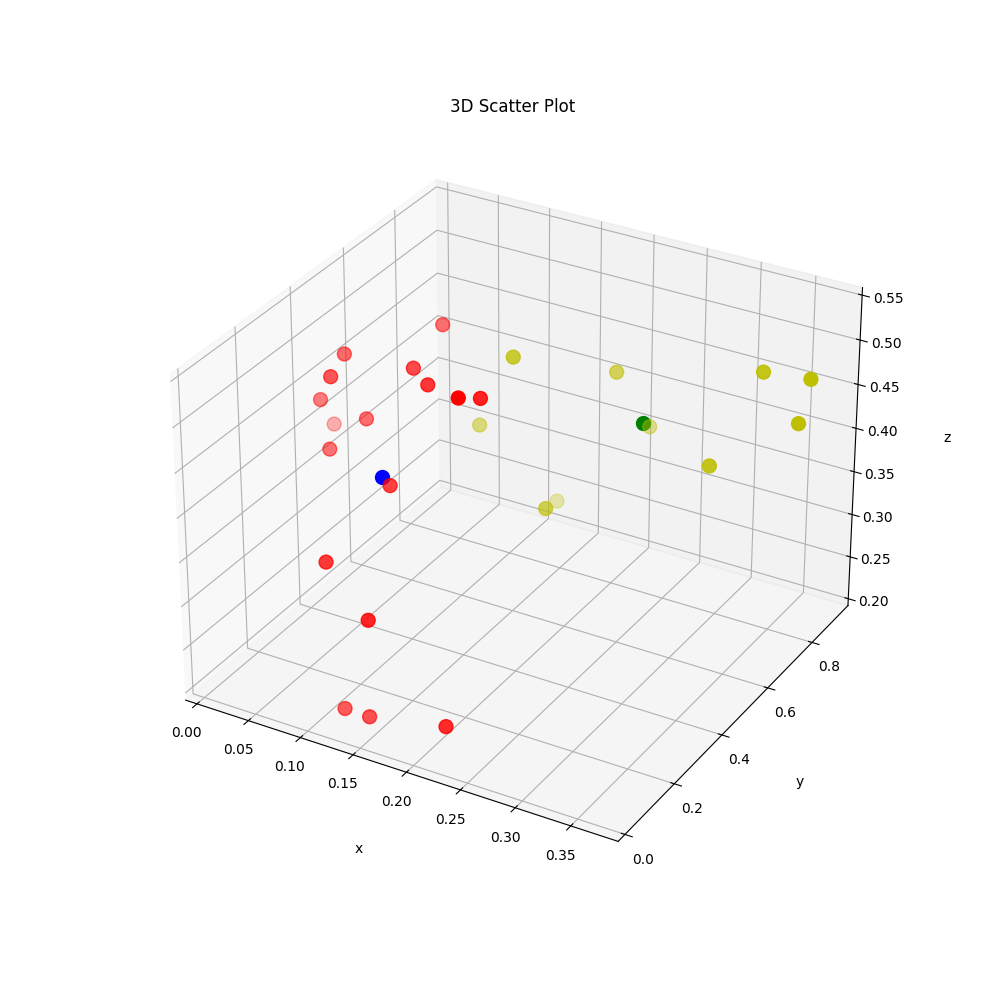

In [4]:
centers_of_mass = center_of_mass(number_of_clusters, clustered_data.copy())

# Test center of mass

%matplotlib widget
x1 = sorted_clusters[73:90, 1]
y1 = sorted_clusters[73:90, 2]
z1 = sorted_clusters[73:90, 3]

x2 = sorted_clusters[90:100, 1]
y2 = sorted_clusters[90:100, 2]
z2 = sorted_clusters[90:100, 3]

print(x2, y2, z2)

print(sorted_clusters[90:100,:])

xc1,yc1,zc1 = centers_of_mass[0, 1:4]
xc2,yc2,zc2 = centers_of_mass[1, 1:4]

print(xc2, yc2, zc2)

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x1, y1, z1, c = 'r', s = 100)
ax.scatter(x2, y2, z2, c = 'y', s = 100)
ax.scatter(xc1,yc1,zc1, c = 'b', s = 100)
ax.scatter(xc2,yc2,zc2, c = 'g', s = 100)
ax.set_title('3D Scatter Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

In [ ]:
def vector_norm(vector):
    return np.sqrt(vector @ vector.T)

def create_unit_vector(vector):
    """Takes a vector and creates a unit vector in the same direction."""
    unit_vector = vector / vector_norm(vector)
    return unit_vector

def create_basis(centers_of_mass):
    """Takes the centers_of_mass array and outputs a transformation matrix."""
    basis = np.zeros_like(centers_of_mass[:, 1:])
    for i in range(len(centers_of_mass[:, None])):
        basis[i] = create_unit_vector(centers_of_mass[i, 1:])

    return basis

transformation_matrix = create_basis(centers_of_mass)

"""
print(np.shape(transformation_matrix@norm_data.T))
print(centers_of_mass)
print(transformation_matrix)
print(transformation_matrix[1,:]@transformation_matrix[1,:].T)
print(transformation_matrix@norm_data.T)
"""

embedded_data = (transformation_matrix@norm_data.T).T

norm_embedded_data = normalize(embedded_data)

# print(embedded_data)
# print(np.shape(embedded_data))
# print(norm_embedded_data)

[[0.58093608 0.47959319]
 [0.25986435 0.40166161]
 [0.69032654 0.86129846]
 [0.59531336 0.79136224]
 [0.69061656 0.71422936]
 [0.56555685 0.51031962]
 [0.52653118 0.64647277]
 [0.39289505 0.28135157]
 [1.09081897 0.95719897]
 [0.39136651 0.52688334]
 [0.56707095 0.56669263]
 [0.76284821 0.82448654]
 [0.23316518 0.16825232]
 [0.36362801 0.52495698]
 [1.082149   0.93523378]
 [0.66666904 0.84093586]
 [0.12228082 0.17557392]
 [0.43386018 0.32424025]
 [0.88637597 1.02492592]
 [0.62143932 0.72117114]
 [0.24636407 0.31533633]
 [0.50179847 0.56215634]
 [0.81705589 0.98190906]
 [0.09948248 0.14678951]
 [0.50332444 0.68652139]
 [0.45323422 0.5680628 ]
 [0.53691585 0.72628865]
 [0.62468354 0.54222004]
 [0.39879813 0.27723699]
 [0.65469772 0.53461257]
 [0.74112679 0.94520385]
 [0.34216829 0.23416675]
 [0.26168958 0.18944259]
 [0.37728448 0.26827946]
 [0.8619742  0.99551445]
 [0.28543697 0.28852757]
 [1.0029514  1.14202596]
 [0.49853446 0.56828502]
 [0.45256646 0.65151111]
 [0.69625474 0.86374147]


# Choose features

Start with excluding the feature that are not int or float.
Later give the unused features numerical values and implement them as well.

Index   type
0       String
26      String
110     String
113     String
114     String
115     String

In [50]:
data = (df.copy()).to_numpy()

for i in range(len(data[0,:])):
    print(i, type(data[0,i]), data[0,i])

# print(data[:,0])

0 <class 'str'> 10006194
1 <class 'int'> 3200000
2 <class 'float'> 56.7421525450848
3 <class 'float'> 16.2917776973397
4 <class 'int'> 48
5 <class 'int'> 143
6 <class 'int'> 480
7 <class 'int'> 36
8 <class 'int'> 0
9 <class 'float'> 60.0
10 <class 'str'> D
11 <class 'int'> 1
12 <class 'int'> 1
13 <class 'int'> 880008
14 <class 'int'> 202321
15 <class 'str'> 02_023_21
16 <class 'int'> 2
17 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 2021-05-07 00:00:00
18 <class 'int'> 4
19 <class 'int'> 143
20 <class 'int'> 0
21 <class 'int'> 880
22 <class 'int'> 8
23 <class 'bool'> False
24 <class 'str'> 0880C1280
25 <class 'str'> C
26 <class 'pandas._libs.tslibs.period.Period'> 2021-05
27 <class 'float'> 0.9143575700355691
28 <class 'float'> 2925944.224113821
29 <class 'float'> 14.889127798218464
30 <class 'float'> 14.978661367769956
31 <class 'int'> 2021
32 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 2021-05-01 00:00:00
33 <class 'int'> 11449
34 <class 'int'> 5
35 <class 'int'> 2
36 <c

In [70]:
del_data = data.copy()

# Removing all non int or float type features looping from the end.
iterate = len(del_data[0,:])-1
for i in range(iterate+1):
    if type(del_data[0,iterate-i]) != float and type(del_data[0,iterate-i]) != int:
        print(iterate-i, type(del_data[0,iterate-i]), data[0,iterate-i])
        del_data = np.delete(del_data, obj=iterate-i, axis=1)

del_data = del_data.astype(float)

for i in range(len(del_data[0,:])):
    print(i, type(del_data[0,i]), del_data[0,i])




153 <class 'str'> InSmallCity
49 <class 'str'> 08
48 <class 'str'> 0880
40 <class 'pandas._libs.tslibs.period.Period'> 2021-05
39 <class 'bytes'> b'\x01\x01\x00\x00\x00\x80\x00\x00\x00\x88\xab!Ac\xfc\xff?\x05\xfeWA'
32 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 2021-05-01 00:00:00
26 <class 'pandas._libs.tslibs.period.Period'> 2021-05
25 <class 'str'> C
24 <class 'str'> 0880C1280
23 <class 'bool'> False
17 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 2021-05-07 00:00:00
15 <class 'str'> 02_023_21
10 <class 'str'> D
0 <class 'str'> 10006194
0 <class 'numpy.float64'> 3200000.0
1 <class 'numpy.float64'> 56.7421525450848
2 <class 'numpy.float64'> 16.2917776973397
3 <class 'numpy.float64'> 48.0
4 <class 'numpy.float64'> 143.0
5 <class 'numpy.float64'> 480.0
6 <class 'numpy.float64'> 36.0
7 <class 'numpy.float64'> 0.0
8 <class 'numpy.float64'> 60.0
9 <class 'numpy.float64'> 1.0
10 <class 'numpy.float64'> 1.0
11 <class 'numpy.float64'> 880008.0
12 <class 'numpy.float64'> 202321.

[3200000 1700000 3500000 ... 1795000 920000 2200000] (91630, 173) (91630, 174)


In [ ]:
# Divide the data set into training and testing data


# Model

In [ ]:
# Boosted tree

# Linear regression

# Neural network